# CSCI 5922 (Spring 2020) Final Project
name: Timothy Mason
***
Music Genre classification using a CRNN as described in the paper blah, blah, blah...

todo: fill in citations and flesh out overview

last.fm dataset citation:

> @INPROCEEDINGS{Bertin-Mahieux2011,
  author = {Thierry Bertin-Mahieux and Daniel P.W. Ellis and Brian Whitman and Paul Lamere},
  title = {The Million Song Dataset},
  booktitle = {{Proceedings of the 12th International Conference on Music Information
	Retrieval ({ISMIR} 2011)}},
  year = {2011},
  owner = {thierry},
  timestamp = {2010.03.07}
}

> Additionally, you can mention / link to this web resource:
> 
> Last.fm dataset, the official song tags and song similarity collection for the Million Song
> Dataset, available at: http://millionsongdataset.com/lastfm

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm      # for easy and attractive progress bars

import hdf5_getters        # https://github.com/tbertinmahieux/MSongsDB/tree/master/PythonSrc
# hdf5_getters.py is Copyright 2010, Thierry Bertin-Mahieux
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

## Functions for importing data

In [2]:
# see http://docs.echonest.com.s3-website-us-east-1.amazonaws.com/_static/AnalyzeDocumentation.pdf for
# detailed discussion of the category data items
def hdf_tree_to_dataframe(msd_path='./MillionSongSubset/data',
                          categories={"artist_name",          # Name of the artist
                                      "release",              # Album name
                                      "title",                # Title of the piece
                                      "year",                 # year released (unreliable - often 0)
                                      "analysis_sample_rate", # sample rate (Hz) for the analysis
                                      "duration",             # length of the piece (seconds)
                                      "tempo",                # tempo of the piece (avg beats per minute)
                                      "beats_start",          # list of time markers (seconds) for beats
                                      "bars_start",           # list of time markers (seconds) for bars
                                      "tatums_start",         # "list of tatum markers, in seconds. Tatums 
                                                              # represent the lowest regular pulse train that
                                                              # a listener intuitively infers from the timing
                                                              # of perceived musical events (segments)."
                                      "segments_start",       # list of time markers (seconds) for segments
                                      "segments_pitches",     # list of 12-ary vectors, each contains relative
                                                              # strength of the notes (pitches) contained in 
                                                              # a segment.  0 = strength(0..1) of the C note, 
                                                              # 1 = strength of C-sharp, 
                                                              # ... 
                                                              # 11 = B
                                      "segments_timbre",      # list of 12-ary vectors, "timbre is the quality
                                                              # of a musical note or sound that distinguishes 
                                                              # different types of musical instruments, or 
                                                              # voices. It is a complex notion also referred 
                                                              # to as sound color, texture, or tone quality, 
                                                              # and is derived from the shape of a segment’s 
                                                              # spectro-temporal surface, independently of 
                                                              # pitch and loudness. "
                                     }, 
                          first = 0, last = None):
    """
    Walk the directory structure of the provided path, and read data from the
    *.h5 files in all subdirectories.

    Parameters
    ----------
    categories: set of keyword strings.  Note:  'track_id' is the index field, so it will always read
        that category, whether it is specified or not.
    msd_path: The path to the root directory of the MSD dataset
    first: Index of the first file to read
    last: Index of the last file to read.  If None, then read entire list of files

    Returns
    -------
    a Pandas dataframe object containing the specified categories of MSD data
    """

    categories.add('track_id')   # categories is type "set", so no worry about duplicates

    file_list = [f for f in Path(msd_path).glob('**/*.h5')]

    if last == None:
        last = len(file_list)
    data = []

    for f in tqdm(file_list[first:last], desc=f"Loading 10k Subset of MSD"):
        h5file = hdf5_getters.open_h5_file_read(f)
        d = {}
        for c in categories:
            t = getattr(hdf5_getters, "get_"+c)(h5file)
            d[c] = t
        h5file.close()
        data.append(d)
    return pd.DataFrame(data).set_index('track_id')

def json_tree_to_dataframe( lfm_path='./lastfm_subset' ):
    """
    Load the tags from all JSON files at the specified directory and its' subdirectories
    into a Pandas DataFrame.  Index by track_id and also keep artist and title for more precise matching
    to the MSD.  Result is filtered to only return entries which have tags in the top-50.  Assumes that
    the list of last.fm top 50 tags is in the file top50_lastfm_tags.csv in the current working directory.
    
    Parameters
    ----------
    lfm_path: The path to the root directory of the last.fm dataset

    Returns
    -------
    a Pandas DataFrame object containing the entire dataset, filtered to only contain entries which
    have tags in the top 50 of last.fm tags.
    """
    
    # load the top 50 tags into a set because set intersection will be an elegant way to only keep those
    # tags which are in the top 50.
    top50 = set(pd.read_csv('top50_lastfm_tags.csv').Tag)
    
    # Appending one record at a time to a Pandas DataFrame is inefficient, so build a simple list
    # in memory, then create the Pandas DataFrame in one shot from that list
    data = []
    for file_path in tqdm([f for f in Path(lfm_path).glob('**/*.json')], desc="Loading last.fm tags"):
        with open(file_path) as json_data:     # with... syntax benefits from automatic file closing
            j = json.load(json_data)
            if j['tags']:      # skip tag-less entries
                # Only keep the tags, and only if they are in the top50 set.  Do the list filtering by
                # using set intersection of the top50 set and use column slice feature of a numpy array to
                # extract just the tag names.  (The JSON file has both the tag name and an integer number
                # for each tag - I don't care about that integer number)
                t = list(top50.intersection(np.array(j['tags'])[:,0]))
                if t:
                    j['top50_tags'] = t
                    data.append(j)
                
         
    return pd.DataFrame(data).set_index('track_id')[['artist','title','top50_tags']] # only keep the useful bits


## Load and merge the datasets

In [3]:
df = hdf_tree_to_dataframe().merge(right=json_tree_to_dataframe(),
                                   how='inner',    # keep only the tracks which are present in both datasets
                                   left_on=('track_id','title','artist_name'), # stringent match criterea
                                   right_on=('track_id','title','artist'),
                                  )


Loading last.fm tags: 100%|██████████| 9330/9330 [00:04<00:00, 2155.55it/s]


### Inspect the final dataset

In [4]:
df

,title,duration,segments_timbre,release,tempo,beats_start,segments_pitches,artist_name,year,bars_start,segments_start,tatums_start,analysis_sample_rate,artist,top50_tags
track_id,,,,,,,,,,,,,,,
TRARRER128F9328521,Liquid Time (composition by John Goodsall),279.35302,"[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...",X Communication : Trilogy II,99.024,"[0.26495, 0.86028, 1.47917, 2.10185, 2.71162, ...","[[0.253, 0.295, 0.256, 0.255, 0.365, 0.256, 0....",Brand X,0,"[0.86028, 3.32671, 5.78675, 8.25191, 10.70588,...","[0.0, 0.43252, 0.60086, 0.94916, 1.34971, 2.02...","[0.11365, 0.26495, 0.41625, 0.56755, 0.71126, ...",22050,Brand X,[chill]
TRARREF128F422FD96,Halloween,216.84200,"[[23.928, -119.362, 33.96, -122.038, 8.715, 18...",Milking The Sacred Cow,92.897,"[0.39241, 1.04773, 1.69575, 2.34571, 3.00003, ...","[[0.146, 0.203, 0.219, 0.209, 0.172, 0.123, 0....",Dead Kennedys,1982,"[1.04773, 3.659, 6.31974, 8.97532, 11.61875, 1...","[0.0, 0.19837, 0.49914, 0.85873, 1.01193, 1.17...","[0.06784, 0.23214, 0.39241, 0.5559, 0.7194, 0....",22050,Dead Kennedys,"[alternative, rock, american, indie, party, pu..."
TRARUOP12903CF2384,What Drives The Weak,283.48036,"[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...",The War Within,84.992,"[0.65324, 1.35712, 2.06418, 2.76881, 3.47509, ...","[[0.937, 0.557, 0.215, 0.198, 0.112, 0.135, 0....",Shadows Fall,2004,"[1.35712, 4.17899, 7.00987, 9.83158, 12.64793,...","[0.0, 0.11324, 0.18916, 0.27188, 0.42181, 0.58...","[0.12569, 0.30125, 0.47681, 0.65324, 0.8288, 1...",22050,Shadows Fall,"[cool, alternative, rock, metal, favorites, se..."
TRARUHU128F92FDC00,Spoonie Is Back,393.63873,"[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...",The Sugar Hill Records Story,135.503,"[0.21007, 0.65246, 1.09485, 1.53651, 1.98112, ...","[[1.0, 0.284, 0.224, 0.217, 0.245, 0.285, 0.38...",Spoonie Gee,0,"[1.53651, 3.73492, 5.93365, 8.15439, 10.3851, ...","[0.0, 0.17891, 0.33379, 0.61823, 0.90853, 1.05...","[0.0626, 0.21007, 0.35753, 0.505, 0.65246, 0.7...",22050,Spoonie Gee,[80s]
TRARIRG128F147FC96,I'm Not Moving,154.93179,"[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...",Face Value,100.042,"[0.15879, 0.76615, 1.367, 1.96635, 2.566, 3.16...","[[0.819, 0.683, 0.6, 0.67, 0.291, 0.274, 0.689...",Phil Collins,1981,"[0.15879, 2.566, 4.96459, 7.35868, 9.76066, 12...","[0.0, 0.10703, 0.43669, 0.67637, 1.01882, 1.33...","[0.15879, 0.46098, 0.76615, 1.06583, 1.367, 1....",22050,Phil Collins,"[classic rock, rock, singer-songwriter, easy l..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRBBYOI128F4256732,Out Of This World,133.25016,"[[0.102, 168.868, 6.486, -31.413, 55.144, -50....",I Can See You,207.238,"[0.25651, 0.5451, 0.83441, 1.12446, 1.42177, 1...","[[0.345, 0.254, 0.161, 0.162, 0.25, 0.542, 0.3...",Black Flag,1985,"[0.5451, 1.714, 2.84583, 4.00887, 5.17191, 6.3...","[0.0, 0.241, 0.34739, 0.45583, 0.90898, 1.2802...","[0.25651, 0.40044, 0.5451, 0.68975, 0.83441, 0...",22050,Black Flag,"[punk, hard rock, soul]"
TRBBYDT128F14805B4,You Can't Hurry Love (Live),174.23628,"[[33.671, 84.55, 202.282, 2.574, 46.344, 64.34...",Serious Hits... Live!,206.941,"[0.35519, 0.65178, 0.94837, 1.2444, 1.54043, 1...","[[0.521, 0.515, 0.559, 0.631, 0.818, 0.722, 0....",Phil Collins,1990,"[1.8372, 3.91027, 5.98162, 8.05196, 10.13462, ...","[0.0, 0.18853, 0.47887, 0.79215, 1.08884, 1.25...","[0.20689, 0.35519, 0.50348, 0.65178, 0.79934, ...",22050,Phil Collins,"[pop, rock, 80s]"
TRBBYFJ128F42A22D4,Jingle Bells,108.19873,"[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...",Christmas Songbook,95.264,"[0.26569, 0.90244, 1.53358, 2.16138, 2.79373, ...","[[1.0, 0.923, 0.508, 0.49, 0.511, 0.522, 0.548...",Jim Reeves,1963,"[0.26569, 2.79373, 5.31379, 7.84467, 10.38659,...","[0.0, 0.12141, 0.41565, 0.56018, 0.74621, 0.86...","[0.26569, 0.58328, 0.90244, 1.21722, 1.53358, ...",22050,Jim Reeves,"[male vocalists, easy listening, country, folk]"


### Sample Data Visualization

Because it looks cool!

### "Amidar (CCCP Mix)" by *Rui Da Silva* on *Amidar*
Tags: ['electronic']

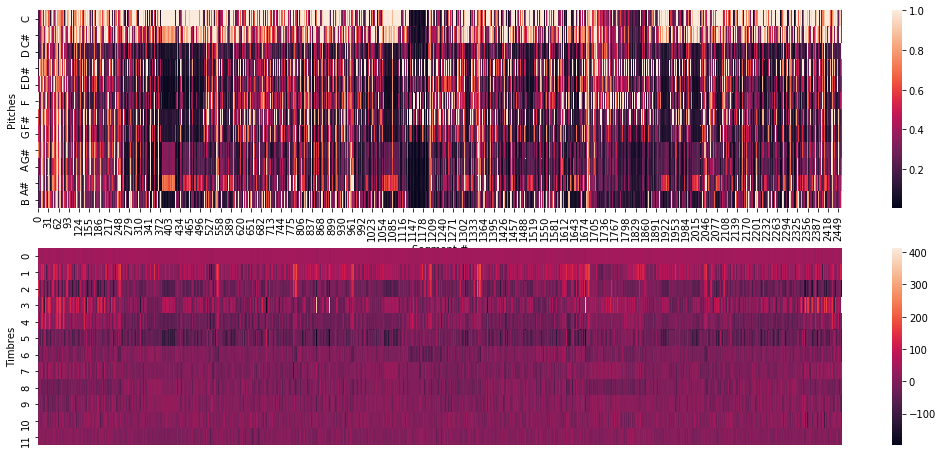

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import random

%matplotlib inline

x = random.randint(0,df.shape[0]-2)

for i in df.index[x:x+1]:
    name = f'### "{df.title[i]}" by *{df.artist_name[i]}* on *{df.release[i]}*'
    if df.year[i] != 0:
        name += f', released {df.year[i]}'
    name += '\n'
    name += f'Tags: {df.top50_tags[i]}'
    display(Markdown(name))
    
    # plot a scatterplot of the segment starts
    plt.figure(figsize=(18,8))

    # plot a heatmap of the pitch data
    plt.subplot(2,1,1)
    ax = sns.heatmap(df.segments_pitches[i].T, 
                     yticklabels=("C", "C#", "D", "D#", "E", "F", "F#", "G",
                                 "G#", "A", "A#", "B")
                    )
    ax.set(ylabel="Pitches")
    ax.set(xlabel="Segment #")

    # plot a heatmap of the timbre data
    plt.subplot(2,1,2)
    ax = sns.heatmap(df.segments_timbre[i].T, xticklabels=False)
    ax.set(ylabel="Timbres")
    plt.show()
    plt.close()
    

In [6]:

xticklabels

NameError: name 'xticklabels' is not defined